In [2]:
#initial dataframe setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from scipy import stats
data = pd.read_csv('crp_trials.csv')
data = data.drop(columns=['Unnamed: 0'])

#Creating distance bins, iteratively increased by 2mm
def bin_distances(dist, binsize=4): #Define function that will take as input a distance and perform floor division by bin size to collapse (group) into an integer representing its bin
    return dist//binsize 

data['dist_bin'] = data.dist.apply(bin_distances)*4 #Add 'dist_bin' column to dataframe

#index subjects from 1 to 24
subj_i_list = []
subj_index = 1
for i in range(data.shape[0]):
    if i == data.shape[0] - 1:
        subj_i_list.append(subj_index)
        break
    elif data.at[i,'subj'] == data.at[i+1,'subj']:
        subj_i_list.append(subj_index)
    else:
        subj_i_list.append(subj_index)
        subj_index += 1
data['subj_i'] = subj_i_list

print(data.dist_bin.nunique())
data.info()

data = data[data.dist_bin <= 80]

ModuleNotFoundError: No module named 'pandas'

In [5]:
def hist(df, varname):
    for bin in set(df.dist_bin):
        binned_df = df[df.dist_bin == bin] #dataframe boolean indexed to only include rows within specified bin
        binned_df_nn = binned_df[binned_df.stim_rel == 'NIZ-NIZ'] #separate binned dataframe by zone
        binned_df_sn = binned_df[binned_df.stim_rel == 'SOZ-NIZ']
        binned_df_ns = binned_df[binned_df.stim_rel == 'NIZ-SOZ']
        binned_df_ss = binned_df[binned_df.stim_rel == 'SOZ-SOZ']

        sns.histplot(data=binned_df, x=binned_df[binned_df.stim_rel == 'NIZ-NIZ'][varname], color='lightsteelblue')
        sns.histplot(data=binned_df, x=binned_df[binned_df.stim_rel == 'SOZ-NIZ'][varname], color='blanchedalmond')
        sns.histplot(data=binned_df, x=binned_df[binned_df.stim_rel == 'NIZ-SOZ'][varname], color='darkseagreen')
        sns.histplot(data=binned_df, x=binned_df[binned_df.stim_rel == 'SOZ-SOZ'][varname], color='lightcoral')
        
        plt.xlabel("Distribution of T_peak_0 Values")
        plt.ylabel('Count')
        plt.title(f"Distribution of T_peak_0 Values at Distance Bin {bin} by Stim_Rel Zone")
        plt.legend(labels=[f'NIZ-NIZ ({binned_df_nn[varname].count()})', f'SOZ-NIZ ({binned_df_sn[varname].count()})', f'NIZ-SOZ ({binned_df_ns[varname].count()})', f'SOZ-SOZ ({binned_df_ss[varname].count()})'])
        plt.savefig(f'../Figures/tp0_bin{bin}_histplot.pdf', transparent=True)
        plt.clf()

hist_plot = hist(data, 't_peak_0')


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

<Figure size 640x480 with 0 Axes>

In [ ]:
#Bootstrap a given CRP parameter using oneway ANOVA as test statistic
def boot_anova(df, varname):
    boot_run = pd.DataFrame(columns = ['run_id', 'dist_bin', 'p_value'])
    run_id = 0
    for bin in set(df.dist_bin):
        if bin <= 80:
            binned_df = df[df.dist_bin == bin] #dataframe boolean indexed to only include rows within specified bin
            binned_df_nn = binned_df[binned_df.stim_rel == 'NIZ-NIZ'] #separate binned dataframe by zone
            binned_df_sn = binned_df[binned_df.stim_rel == 'SOZ-NIZ']
            binned_df_ns = binned_df[binned_df.stim_rel == 'NIZ-SOZ']
            binned_df_ss = binned_df[binned_df.stim_rel == 'SOZ-SOZ']
            
            binned_df_nn['weights'] = 1/binned_df_nn[varname].notna().sum() #populate 'weights' column with scalar value of total number of values in given dataframe
            binned_df_sn['weights'] = 1/binned_df_sn[varname].notna().sum()
            binned_df_ns['weights'] = 1/binned_df_ns[varname].notna().sum()
            binned_df_ss['weights'] = 1/binned_df_ss[varname].notna().sum()
            
            for i in range(250): #subsample each EV values for each zone 250 times, then run test stat (generating 250 p-values per distance bin)
                if binned_df_ss[varname].notna().count() / 2 == 1:
                    n = binned_df_ss[varname].notna().count()
                else:
                    n = binned_df_ss[varname].notna().count() // 2
                    
                sampled_df_nn = binned_df_nn.sample(n=n, weights=binned_df_nn['weights'], replace=True) #subsample with replacement by zone from boolean indexed dataframe
                sampled_df_sn = binned_df_sn.sample(n=n, weights=binned_df_sn['weights'], replace=True)
                sampled_df_ns = binned_df_ns.sample(n=n, weights=binned_df_ns['weights'], replace=True)
                sampled_df_ss = binned_df_ss.sample(n=n, weights=binned_df_ss['weights'], replace=True)
                
                a = sampled_df_nn[varname] #store EV distribution from each sample by zone (4 total)
                b = sampled_df_sn[varname]
                c = sampled_df_sn[varname]
                d = sampled_df_ss[varname]
                #print(a.notna().sum(), b.notna().sum())
                F, p = stats.f_oneway(a, b, c, d) #run oneway ANOVA on the four EV distributions

                new_row = {'run_id': pd.to_numeric(run_id), 'dist_bin': pd.to_numeric(bin), 'p_value': pd.to_numeric(p)}
                boot_run.loc[len(boot_run)] = new_row #append rows created during this iteration of sampling to bs_run dataframe, then repeat

                run_id += 1
            else:
                continue
    return boot_run

boot_run_a = boot_anova(data, 'alpha_prime') #dataframe with mean EV for each sample iteration (250), indexed by distance bin (55) and stim_rel category (4), 55000 rows total
boot_run_a.info()

In [6]:
#Bootstrap a given CRP parameter using Kruskal-Wallis H-test as test statistic
def boot_kruskal(df, varname):
    boot_run = pd.DataFrame(columns = ['run_id', 'dist_bin', 'p_value'])
    run_id = 0
    df = df[df.t_peak_0.notna()]
    for bin in set(df.dist_bin):
        if bin <= 80:
            binned_df = df[df.dist_bin == bin] #dataframe boolean indexed to only include rows within specified bin
            binned_df_nn = binned_df[binned_df.stim_rel == 'NIZ-NIZ'] #separate binned dataframe by zone
            binned_df_sn = binned_df[binned_df.stim_rel == 'SOZ-NIZ']
            binned_df_ns = binned_df[binned_df.stim_rel == 'NIZ-SOZ']
            binned_df_ss = binned_df[binned_df.stim_rel == 'SOZ-SOZ']
            
            binned_df_nn['weights'] = 1/binned_df_nn[varname].notna().sum() #populate 'weights' column with scalar value of total number of values in given dataframe
            binned_df_sn['weights'] = 1/binned_df_sn[varname].notna().sum()
            binned_df_ns['weights'] = 1/binned_df_ns[varname].notna().sum()
            binned_df_ss['weights'] = 1/binned_df_ss[varname].notna().sum()
            
            for i in range(250): #subsample each EV values for each zone 250 times, then run test stat (generating 250 p-values per distance bin)
                if binned_df_ss[varname].notna().count() / 2 == 1:
                    n = binned_df_ss[varname].notna().count()
                else:
                    n = binned_df_ss[varname].notna().count() // 2
                    
                sampled_df_nn = binned_df_nn.sample(n=n, weights=binned_df_nn['weights'], replace=True) #subsample with replacement by zone from boolean indexed dataframe
                sampled_df_sn = binned_df_sn.sample(n=n, weights=binned_df_sn['weights'], replace=True)
                sampled_df_ns = binned_df_ns.sample(n=n, weights=binned_df_ns['weights'], replace=True)
                sampled_df_ss = binned_df_ss.sample(n=n, weights=binned_df_ss['weights'], replace=True)
                
                a = sampled_df_nn[varname] #store EV distribution from each sample by zone (4 total)
                b = sampled_df_sn[varname]
                c = sampled_df_sn[varname]
                d = sampled_df_ss[varname]
                #print(a.notna().sum(), b.notna().sum())
                H, p = stats.kruskal(a, b, c, d) #run Kruskal-Wallis H-test on the four EV distributions

                new_row = {'run_id': pd.to_numeric(run_id), 'dist_bin': pd.to_numeric(bin), 'p_value': pd.to_numeric(p)}
                boot_run.loc[len(boot_run)] = new_row #append rows created during this iteration of sampling to bs_run dataframe, then repeat

                run_id += 1
            else:
                continue
    return boot_run

boot_run_k = boot_kruskal(data, 't_peak_0') #dataframe with mean EV for each sample iteration (250), indexed by distance bin (55) and stim_rel category (4), 55000 rows total
boot_run_k.info()

/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_85375/3180063284.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binned_df_nn['weights'] = 1/binned_df_nn[varname].notna().sum() #populate 'weights' column with scalar value of total number of values in given dataframe
/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_85375/3180063284.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binned_df_sn['weights'] = 1/binned_df_sn[varname].notna().sum()
/var/folders/x6/d9qjznp95k7dlyz6y09v

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   run_id    4000 non-null   int64  
 1   dist_bin  4000 non-null   float64
 2   p_value   3750 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 125.0 KB


In [ ]:
#Bootstrap a given CRP parameter using pair-wise Wilcoxon
def boot_wilcoxon(df, varname):
    boot_run = pd.DataFrame(columns = ['run_id', 'dist_bin', 'p_value', 'Stim_Rel_Comparison'])
    run_id = 0
    df = df[df.t_peak_0.notna()]
    for bin in set(df.dist_bin):
        if bin <= 80:
            binned_df = df[df.dist_bin == bin] #dataframe boolean indexed to only include rows within specified bin
            binned_df_nn = binned_df[binned_df.stim_rel == 'NIZ-NIZ'] #separate binned dataframe by zone
            binned_df_sn = binned_df[binned_df.stim_rel == 'SOZ-NIZ']
            binned_df_ns = binned_df[binned_df.stim_rel == 'NIZ-SOZ']
            binned_df_ss = binned_df[binned_df.stim_rel == 'SOZ-SOZ']
            
            binned_df_nn['weights'] = 1/binned_df_nn[varname].notna().sum() #populate 'weights' column with scalar value of total number of values in given dataframe
            binned_df_sn['weights'] = 1/binned_df_sn[varname].notna().sum()
            binned_df_ns['weights'] = 1/binned_df_ns[varname].notna().sum()
            binned_df_ss['weights'] = 1/binned_df_ss[varname].notna().sum()
            
            for i in range(250): #subsample each EV values for each zone 250 times, then run test stat (generating 250 p-values per distance bin)
                if binned_df_ss[varname].notna().count() / 2 == 1:
                    n = binned_df_ss[varname].notna().count()
                else:
                    n = binned_df_ss[varname].notna().count() // 2
                    
                sampled_df_nn = binned_df_nn.sample(n=n, weights=binned_df_nn['weights'], replace=True) #subsample with replacement by zone from boolean indexed dataframe
                sampled_df_sn = binned_df_sn.sample(n=n, weights=binned_df_sn['weights'], replace=True)
                sampled_df_ns = binned_df_ns.sample(n=n, weights=binned_df_ns['weights'], replace=True)
                sampled_df_ss = binned_df_ss.sample(n=n, weights=binned_df_ss['weights'], replace=True)
                '''
                sns.histplot(data=sampled_df_nn, x=sampled_df_nn[varname], color='b')
                sns.histplot(data=sampled_df_sn, x=sampled_df_sn[varname], color='r')
                sns.histplot(data=sampled_df_ns, x=sampled_df_ns[varname], color='g')
                sns.histplot(data=sampled_df_ss, x=sampled_df_ss[varname], color='y')
                
                plt.xlabel('Distribution of Sampled EV Values')
                plt.ylabel('Count')
                plt.title(f'Distribution of Sampled EV Values at Distance Bin {bin} by Stim_Rel Zone')
                plt.legend(labels=[f'NIZ-NIZ ({sampled_df_nn[varname].count()})', f'SOZ-NIZ ({sampled_df_sn[varname].count()})', f'NIZ-SOZ ({sampled_df_ns[varname].count()})', f'SOZ-SOZ ({sampled_df_ss[varname].count()})'])
                plt.savefig(f'../Rotation/sampled_ev_bin{bin}_histplot.pdf', transparent=True)
                plt.clf()
                
                repeats_nn = binned_df_nn[varname].count() - sampled_df_nn[varname].nunique()
                repeats_sn = binned_df_sn[varname].count() - sampled_df_sn[varname].nunique()
                repeats_ns = binned_df_ns[varname].count() - sampled_df_ns[varname].nunique()
                repeats_ss = binned_df_ss[varname].count() - sampled_df_ss[varname].nunique()
                #print(f"In dist bin {bin}, there are {repeats_nn} NIZ-NIZ repeats,{repeats_sn} SOZ-NIZ repeats, {repeats_ns} NIZ-SOZ repeats,and {repeats_ss} SOZ-SOZ repeats.")
                '''
                a = sampled_df_nn[varname] #store EV distribution from each sample by zone (4 total)
                b = sampled_df_sn[varname]
                c = sampled_df_ns[varname]
                d = sampled_df_ss[varname]
                #print(a.notna().sum(), b.notna().sum())
                W, p = stats.wilcoxon(d, a)
                new_row = {'run_id': pd.to_numeric(run_id), 'dist_bin': pd.to_numeric(bin), 'p_value': pd.to_numeric(p), 'Stim_Rel_Comparison': 'SOZ-SOZ to NIZ-NIZ'}
                boot_run.loc[len(boot_run)] = new_row #append rows created during this iteration of sampling to bs_run dataframe, then repeat

                W, p = stats.wilcoxon(d, b)
                new_row = {'run_id': pd.to_numeric(run_id), 'dist_bin': pd.to_numeric(bin), 'p_value': pd.to_numeric(p), 'Stim_Rel_Comparison': 'SOZ-SOZ to SOZ-NIZ'}
                boot_run.loc[len(boot_run)] = new_row #append rows created during this iteration of sampling to bs_run dataframe, then repeat

                W, p = stats.wilcoxon(d, c)
                new_row = {'run_id': pd.to_numeric(run_id), 'dist_bin': pd.to_numeric(bin), 'p_value': pd.to_numeric(p), 'Stim_Rel_Comparison': 'SOZ-SOZ to NIZ-SOZ'}
                boot_run.loc[len(boot_run)] = new_row #append rows created during this iteration of sampling to bs_run dataframe, then repeat

                W, p = stats.wilcoxon(b, c)
                new_row = {'run_id': pd.to_numeric(run_id), 'dist_bin': pd.to_numeric(bin), 'p_value': pd.to_numeric(p), 'Stim_Rel_Comparison': 'SOZ-NIZ to NIZ-SOZ'}
                boot_run.loc[len(boot_run)] = new_row #append rows created during this iteration of sampling to bs_run dataframe, then repeat

                run_id += 1
            else:
                continue
    return boot_run

boot_run_w = boot_wilcoxon(data, 't_peak_0') #dataframe with mean EV for each sample iteration (250), indexed by distance bin (55) and stim_rel category (4), 55000 rows total
boot_run_w.info()

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Omnibus Test of Response Delay Across Distance')

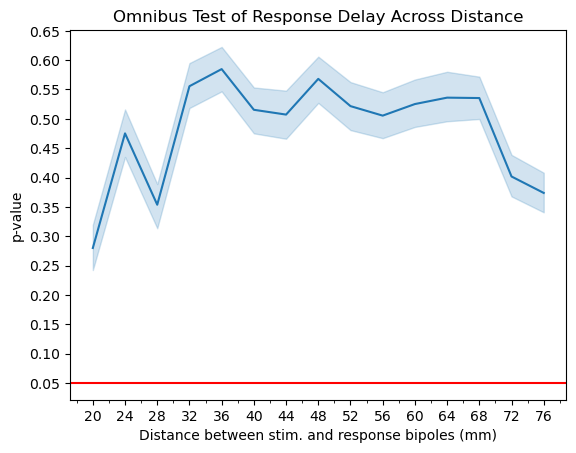

In [11]:
#p-value lineplot for EV Kurskal-Wallis bootstrap
plot = sns.lineplot(data=boot_run_k, x='dist_bin', y='p_value')
plot.xaxis.set_major_locator(ticker.MultipleLocator(4))
plot.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plot.xaxis.set_minor_locator(ticker.MultipleLocator(2))
plot.axhline(y=0.05, color='red')
plt.xlabel('Distance between stim. and response bipoles (mm)')
plt.ylabel('p-value')
plt.title('Omnibus Test of Response Delay Across Distance')
#plt.savefig('../Figures/ev_dist_boot.pdf', transparent=True)

In [ ]:
#p-value lineplot for pairwise EV Wilcoxon bootstrap
plot = sns.lineplot(data=boot_run_w, x='dist_bin', y='p_value', hue='Stim_Rel_Comparison')
plot.xaxis.set_major_locator(ticker.MultipleLocator(4))
plot.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plot.xaxis.set_minor_locator(ticker.MultipleLocator(2))
plot.axhline(y=0.05, color='red')
plt.xlabel('Distance between stim. and response bipoles (mm)')
plt.ylabel('p-value')
plt.title('Pairwise Significance of Explained Variance Across Distance')
#plt.savefig('../Figures/pw_ev_dist_boot.pdf', transparent=True)

In [ ]:
#p-value lineplot for a' ANOVA bootstrap
plot = sns.lineplot(data=boot_run_a_ap, x='dist_bin', y='p_value')
plot.xaxis.set_major_locator(ticker.MultipleLocator(4))
plot.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plot.xaxis.set_minor_locator(ticker.MultipleLocator(2))
plot.axhline(y=0.05, color='red')
plt.xlabel('Distance between stim. and response bipoles (mm)')
plt.ylabel('p-value')
plt.title("Omnibus Test of Alpha' Across Distance")
#plt.savefig('../Figures/ap_dist_boot.pdf', transparent=True)

In [ ]:
#Correlate response delay (t_peak_0) to regions
data_nn = data[data.stim_rel == 'NIZ-NIZ']
data_sn = data[data.stim_rel == 'SOZ-NIZ']
data_ns = data[data.stim_rel == 'NIZ-SOZ']
data_ss = data[data.stim_rel == 'SOZ-SOZ']

#F, p = stats.kruskal(data_nn.t_peak_0.notna(), data_sn.t_peak_0.notna(), data_ns.t_peak_0.notna(), data_ss.t_peak_0.notna())
#print(p)

#Correlate response delay (t_peak_0) to regions, by distance bin
for bin in set(data.dist_bin):
    if bin <= 80:
        binned = data[data.dist_bin == bin] #dataframe boolean indexed to only include rows within specified bin
        binned_nn = binned[binned.stim_rel == 'NIZ-NIZ'] #separate binned dataframe by zone
        binned_sn = binned[binned.stim_rel == 'SOZ-NIZ']
        binned_ns = binned[binned.stim_rel == 'NIZ-SOZ']
        binned_ss = binned[binned.stim_rel == 'SOZ-SOZ']
        
        F, p = stats.kruskal(binned_nn.t_peak_0.notna(), binned_sn.t_peak_0.notna(), binned_ns.t_peak_0.notna(), binned_ss.t_peak_0.notna())
        print(f'p-value at distane bin {bin}: {p}')

Text(0, 0.5, 'Response Delay (ms)')

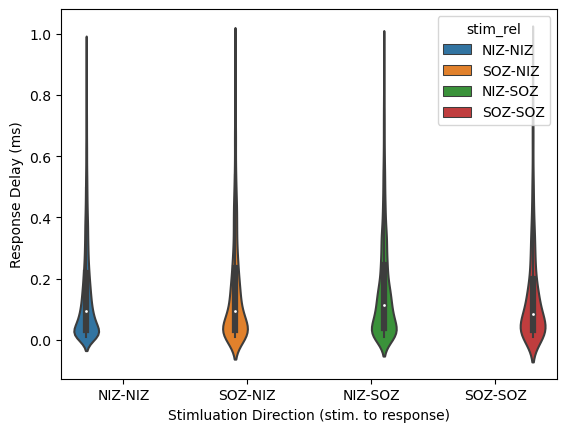

In [7]:
#Violinplot for response delay across regiosn
cols = ['NIZ-NIZ', 'SOZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ']
sns.violinplot(data[data.stim_rel.isin(cols)], y='t_peak_0', x='stim_rel', hue='stim_rel')
plt.xlabel('Stimluation Direction (stim. to response)')
plt.ylabel('Response Delay (ms)')

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

Text(0.5, 1.0, 'Distance Analysis of Response Delay Between Regions')

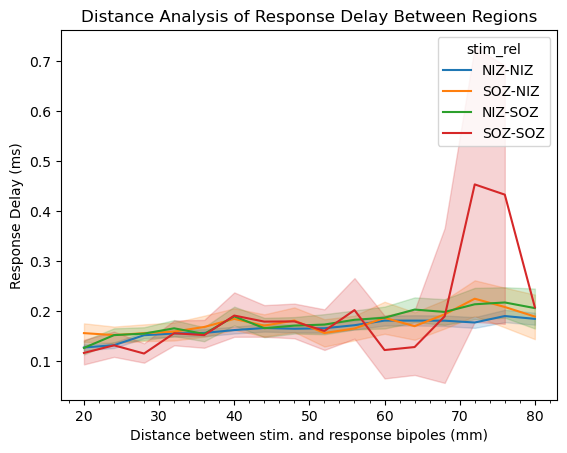

In [8]:
#lineplot of response delays across distance bins, by region

plot = sns.lineplot(data=data, x='dist_bin', y='t_peak_0', hue='stim_rel')
#plot.xaxis.set_major_locator(ticker.MultipleLocator(4))
#plot.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plot.xaxis.set_minor_locator(ticker.MultipleLocator(2))
plt.xlabel('Distance between stim. and response bipoles (mm)')
plt.ylabel('Response Delay (ms)')
plt.title('Distance Analysis of Response Delay Between Regions')
#plt.savefig('../Figures/pw_ev_dist_boot.pdf', transparent=True)